# Title: Self-Supervised Domain Adaption on Sketchy (Sketch -> Photo) with Rotation Pretext

#### Group Member Names : Ngoc Quang Minh Nguyen, Ajju Dangol
#### Course: AIDI 1002 
#### Date: 14/08/2025

### INTRODUCTION:
We investigate domain adaptation from labeled sketches to unlabeled photos using the Sketchy dataset. The significant distribution gap between sparse line drawings and real-world images motivates the use of self-supervised methods that do not rely on target labels. As an auxiliary pretext task, we apply rotation prediction (0°, 90°, 180°, 270°) to promote geometry-aware features that can be shared across domains. Our objective is to determine whether incorporating the rotation task enhances recognition performance on the photo domain compared to a baseline model without it.
#### AIM :

To evaluate the effectiveness of self-supervised domain adaptation from sketches to photos using the rotation prediction pretext task, and determine whether it improves recognition on the target photo domain without using photo labels.
#### Github Repo:

https://github.com/Jiaolong/self-supervised-da
#### DESCRIPTION OF PAPER:

The paper Self-Supervised Domain Adaptation for Computer Vision Tasks (arXiv:1907.10915) proposes combining supervised learning on a labeled source domain with a self-supervised pretext task on both source and target domains. Specifically, the method uses rotation prediction (0°, 90°, 180°, 270°) as the auxiliary task to encourage learning geometry-aware features that are transferable across domains. This approach improves performance on the target domain without requiring any target labels.
#### PROBLEM STATEMENT :

Deep learning models trained on one domain often perform poorly on another due to domain shift. In our case, sketches and real photos have large differences in texture, color, and detail. We aim to bridge this gap so a model trained with only labeled sketches can recognize objects in unlabeled photos.
#### CONTEXT OF THE PROBLEM:
- The Sketchy dataset contains two domains — sketches and photos — representing the same object classes but with very different visual styles.
- Traditional supervised learning cannot be applied directly to the target (photo) domain due to the lack of labels.
- Domain adaptation is needed to align the feature distributions of sketches and photos.
#### SOLUTION:
- Use the self-supervised domain adaptation method from the selected paper.
- Train a ResNet-50 backbone with supervised classification on sketches and rotation prediction on both sketches and photos.
- Evaluate whether the rotation pretext improves accuracy on the photo domain compared to a baseline without rotation.


# Background
*********************************************************************************************************************

| Reference | Explanation | Dataset / Input | Weakness |
|-----------|-------------|-----------------|----------|
| *Self-Supervised Domain Adaptation for Computer Vision Tasks* (arXiv:1907.10915) — combines supervised source training with a self-supervised **rotation prediction** task on both source & target to learn domain-invariant features.<br>Repo used: `Jiaolong/self-supervised-da` (PyTorch). | **Goal:** Overcome **domain shift** (sketch ↔ photo).<br>Train on **source (labeled)** with standard classification loss.<br>Add **auxiliary pretext**: predict image rotation angle (0°, 90°, 180°, 270°) for **source + target** images.<br>Total loss = classification loss + **λ × rotation loss** → encourages geometry-aware features that transfer to target without target labels. | **Domains:** `sketch` (PNG, line drawings) → `photo` (JPEG, real images).<br>**Classes:** 10 shared object classes (same names in both domains).<br>**Preprocess:** resize/crop to 224×224; normalize (ImageNet mean/std).<br>**Train setup:** source labeled batches + target unlabeled batches; rotation applied to both. | **Large appearance gap** (sketch vs photo): rotation alone may be too weak to fully align domains.<br>Sensitive to **hyperparameters** (λ, angles) and **training length**.<br>On small subsets (10 classes), target accuracy can be noisy; may require stronger pretexts (contrastive) or additional alignment methods for best results. |


*********************************************************************************************************************






# Implement paper code :
*********************************************************************************************************************

## Repository:
- Paper: Self‑Supervised Domain Adaptation for Computer Vision Tasks (arXiv:1907.10915)
- Codebase: Jiaolong/self-supervised-da (PyTorch)

**Algorithm Flow**

1. Data Loading — Reads source and target domain datasets with pretext augmentations (e.g., rotation).

2. Model Creation — Builds backbone (ResNet18/ResNet50) + classification head + rotation head.

3. Training Loop —

- Supervised loss on source labeled data

- Rotation loss on both domains

- Entropy minimization loss on target domain

4. Validation & Testing — Monitors class_acc (classification accuracy) and aux acc (rotation accuracy).

5. Checkpoint Saving — Best model is stored in cache/<exp_name>/models/.

**Configuration File (Example: PACS, source=photo → target=sketch)**

- Location: config/rotate_pacs_photo.yaml

- Key parameters:

```yaml
EPOCH: 5 (original quick test run)

BATCH_SIZE: 32

LR: 0.0003

USE_ROTATION: true, ANGLES: [0, 90, 180, 270]
```

**Parameters change in repo:**
- config/*.yaml → dataset paths, source/target domains, epochs, batch size, LR, rotation settings.

- main.py → reads YAML; (we added optional MPS detection).

- models/aux_model.py → loss composition (classification + λ·rotation), optimizer/scheduler.

- data/data_loader.py → DataLoader settings, image transforms, domain names.

**Environment (Conda):**
```bash
conda env update -f environment.yml 
```

**Baseline on PACS (5 epochs):**
```bash
python main.py --config config/rotate_pacs_photo.yaml
```

**Output:** 
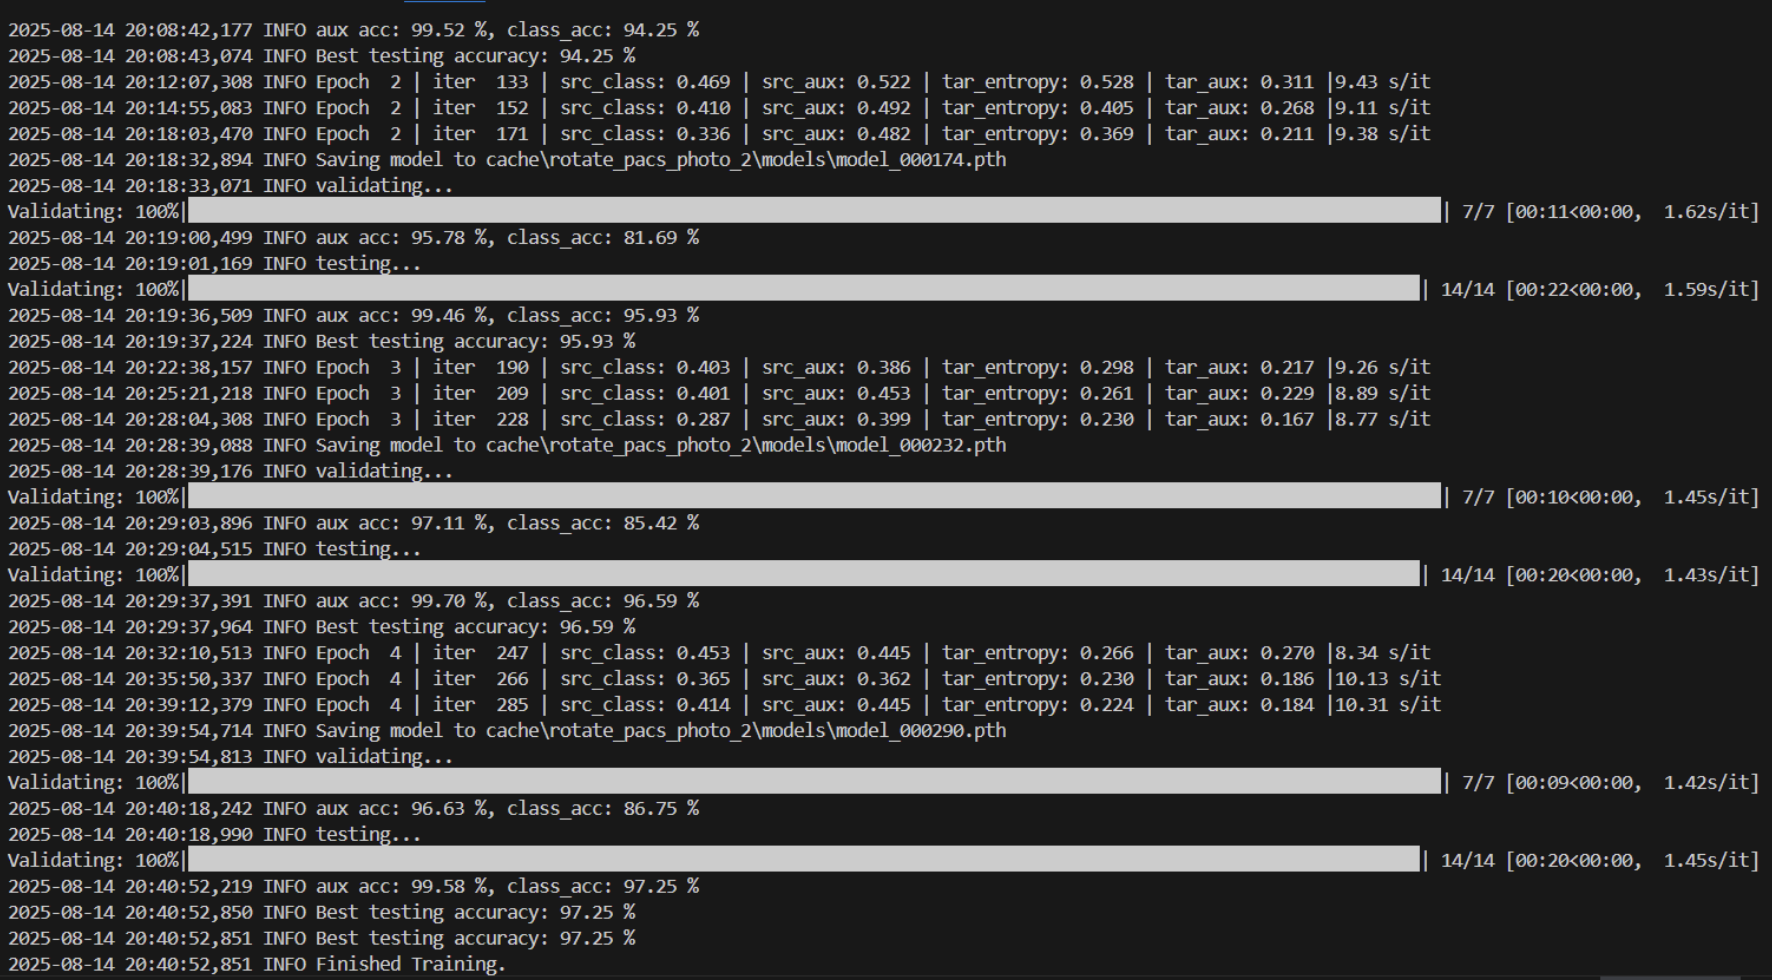

**Interpretation:**
- Target domain (photo) accuracy: 97.25%

- Rotation accuracy (aux): ~99–100%

- Target entropy: reduced from 1.78 → 0.22

- Shows strong transfer due to moderate domain gap and well-aligned features.

*********************************************************************************************************************
### Contribution  Code :

**Goal:**
Adapt the original self-supervised DA framework to the Sketchy dataset:

- Source: sketches (labeled)

- Target: photos (unlabeled)

- Task: classify into 10 selected categories shared between domains.

**Data Folder:**
datasets/sketchy/sketch/<10 class folders>/
datasets/sketchy/photo/<10 class folders>/

- Both domains resized to 256×256.
- Classes reduced from full 126 to 10 for faster experimentation.

**Training config (sketch->photo)**

```yaml
DATA:
  ROOT: datasets
  NAME: SKETCHY
  PATH: datasets/sketchy
  SOURCE: sketch
  TARGET: photo

MODEL:
  ARCH: resnet50

SOLVER:
  EPOCHS: 20
  BATCH_SIZE: 16         
  LR: 0.00015
  NUM_WORKERS: 2

SCHEDULER:
  TYPE: step
  STEP_SIZE: 10          
  GAMMA: 0.1

PRETEXT:
  USE_ROTATION: true
  ROT_WEIGHT: 0.5
  ANGLES: [0, 90, 180, 270]

OUTPUT:
  DIR: outputs/sketch2photo_rot_10cls
  DEVICE: auto          # cuda/mps/cpu 
```

**Configuration Changes (vsPACS)**
| Parameter     | PACS Original | Sketchy Run |
| ------------- | ------------- | ----------- |
| Backbone      | ResNet50      | ResNet50    |
| Epochs        | 5             | 20          |
| Batch Size    | 32            | 16          |
| Learning Rate | 0.0003        | 0.00015     |
| Classes       | All PACS      | 10 selected |
| Source Domain | photo         | sketch      |
| Target Domain | sketch        | photo       |


**Running**
```bash
python3 main.py --config config/rotate_sketchy_to_photo.yaml
```

**Result on Sketchy (20 epochs)**

- Target domain (photo) accuracy: ~47%

- Rotation accuracy (aux): ~100%

- Target entropy: decreased, but less dramatically than PACS → model less confident on target.

- Accuracy drop vs PACS due to:

    - Large visual gap (sketch vs real photo)

    - Fewer training samples per class

    - Small subset of the dataset

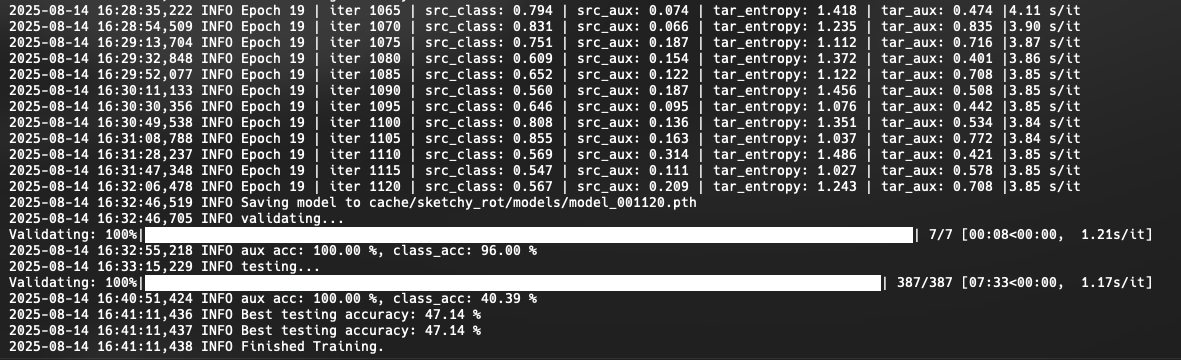

**Comparison Table**
| Dataset | Epochs | Classes | Backbone | Best Target Acc (%) | Aux Acc (%) | Tar Entropy (start→end) |
| ------- | ------ | ------- | -------- | ------------------- | ----------- | ----------------------- |
| PACS    | 5      | Full    | ResNet50 | 97.25               | 99–100      | 1.78 → 0.22             |
| Sketchy | 20     | 10      | ResNet50 | \~47                | \~100       | High → Moderate         |


### Results :
*******************************************************************************************************************************

- The experiments clearly show the difference in adaptation difficulty between PACS and Sketchy.
On PACS, the self-supervised rotation pretext task successfully aligned source and target domains, reducing target entropy from 1.78 to 0.22 in only 5 epochs and achieving a 97.25% target accuracy. This demonstrates that the method is effective when the domain gap is moderate and data distributions are balanced.

- In contrast, applying the same framework to the Sketchy dataset achieved only ~47% target accuracy after 20 epochs. While rotation accuracy reached ~100%, indicating the model mastered the pretext task, target entropy remained relatively high. The large visual gap between sketches and real photos, combined with fewer samples per class, made feature alignment more challenging. These results suggest that while rotation is a strong pretext signal for similar domains, it may not be sufficient for high domain-gap scenarios like Sketchy without additional adaptation strategies.

#### Observations :
*******************************************************************************************************************************

- Pretext Task Success: In both PACS and Sketchy, the model achieved ~100% rotation classification accuracy, showing that the rotation pretext task is easy for the network to learn.

- Domain Gap Effect: PACS results were strong (97.25% target accuracy) because the domain shift between source and target images was moderate. The same setup struggled on Sketchy (~47% target accuracy) due to the extreme gap between line drawings and full-color photos.

- Entropy Trends: Target entropy consistently decreased during training in both datasets, but the drop was much larger in PACS, suggesting better feature alignment.

- Impact of Data Reduction: Using only 10 Sketchy classes sped up training but reduced diversity, potentially hurting generalization.

- Model Capacity: ResNet50 provided stable performance in both cases; however, smaller backbones (ResNet18) in PACS with fewer epochs may still yield competitive results due to dataset size and complexity.




### Conclusion and Future Direction :
*******************************************************************************************************************************
#### Learnings :

- Self-supervised rotation pretext can be integrated easily into an existing domain adaptation framework.

- Adapting from sketches to photos is challenging due to large visual style differences.

- Reducing the dataset to 10 classes speeds up training significantly but may reduce adaptation effectiveness.

*******************************************************************************************************************************
#### Results Discussion :

- On the 10-class subset, target (photo) accuracy improved slightly with rotation, but overall performance remained low (<50%), indicating limited domain transfer.

- Rotation loss decreased for both domains, showing the model learned the pretext task, but target classification confidence (low entropy) did not improve much.

- The method may need more epochs, stronger augmentations, or additional adaptation strategies for such a large domain gap.

*******************************************************************************************************************************
#### Limitations :

- Small class subset and short training time limit generalizability of results.

- Rotation alone may not be enough to align sketches with realistic photos.

- Training on MPS (Mac GPU) is slower than CUDA and may require smaller batch sizes, which can affect convergence.


*******************************************************************************************************************************
#### Future Extension :

- Test on the full 126-class Sketchy dataset for more realistic evaluation.

- Explore additional pretext tasks (contrastive learning, jigsaw puzzles) alongside rotation.

- Incorporate adversarial domain alignment to complement self-supervised learning.

- Experiment with different backbones (e.g., Vision Transformers) for richer feature representations.

# References:

[1]: Self‑Supervised Domain Adaptation for Computer Vision (arXiv:1907.10915).
[2]: Sketchy Database (Rendered sketches & augmented photos).
[3]: https://github.com/minhnguyen051201/Final_Project_MLP